In [1]:
from cuopt import routing
from cuopt.routing import utils
import cudf
import pandas as pd

# Priority Routing
## Capacitated Vehicle Routing Problem with Soft Time Windows (CVRPSTW)

Loyalty (or Preferred) customer programs help companies to reward repeat customers and enhance their overall business offering. While the best possible customer service is always the goal, loyalty programs provide a mechanism for reinforcing the relationship with the customers that drive business revenue.

In this scenario we have a set of deliveries with target time windows for delivery that do not represent a feasible solution given the delivery vehicles that are available. We would still like to deliver all the packages even if some of them are a little behind schedule. However, we would like to prioritize the deliveries of customers in our loyalty program to minimize the delay these customers experience.

We also want to optimize according to a business defined cost objective that is a combination of business relevant metrics. To track time window constraints we will pass a time matrix as a constraint checking "secondary matrix".


### Problem Details:
- 8 Locations each with an associated demand
    - 1 Distribution Center 
        - distribution center demand: [0]
        - hours of operation: [0,24]
    - 7 Service Locations
        - demand for deliveries: [1, 1, 1, 1, 1, 1, 1]
        - delivery time windows: [[9,10],[9,10],[9,10],[10,11],[10,11],[10,11],[9,10]]
        - service location service times: [ 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
        - loyalty program member: [1, 0, 0, 0, 1, 0, 1]

- 3 Delivery vehicles each with an associated capacity
    - 3 delivery vehicles
        - capacity for deliveries: [3, 3, 3]

Below we visualize the delivery locations with respect to the distribution center. The cost from all locations to all other locations (a cost matrix) will be required for optimization. To see an example of cost matrix generation from map data or a waypoint graph, refer to the [cost_matrix_creation.ipynb](cost_matrix_creation.ipynb) notebook.  For the purpose of this simple example we will omit the cost matrix calculation.

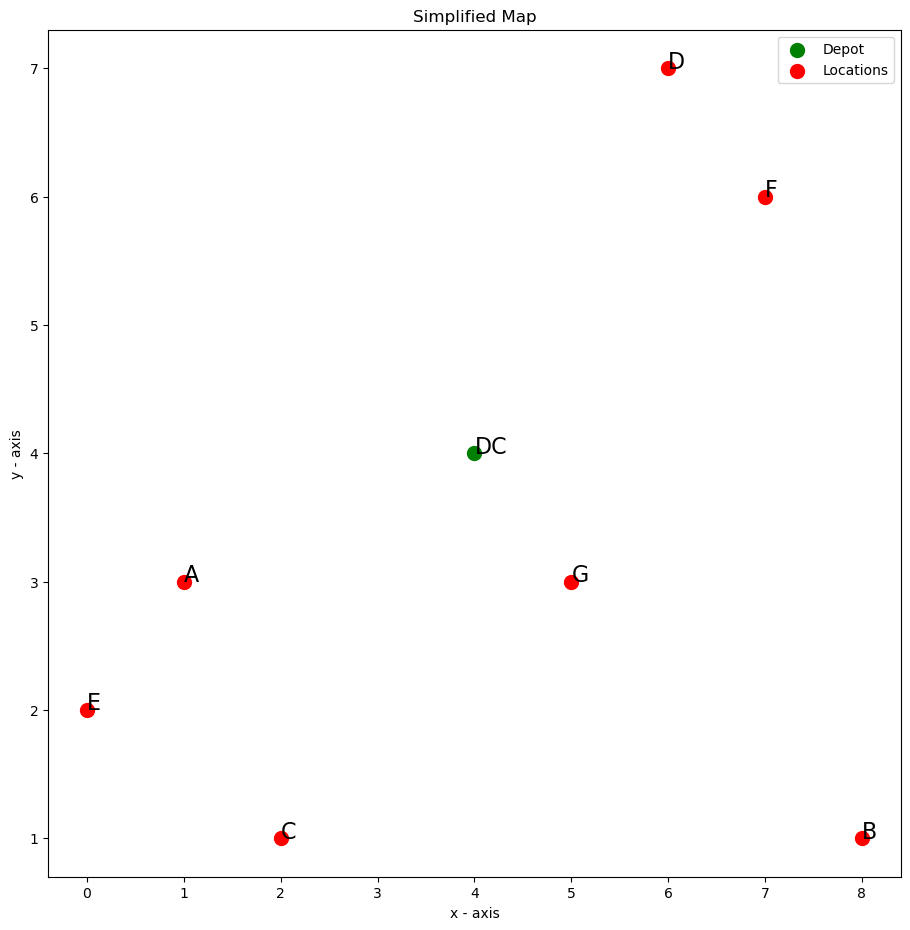

In [2]:
location_names       = [      "DC",          "A",    "B",    "C",    "D",    "E",    "F",    "G"  ]
location_coordinates = [     [4, 4],        [1, 3], [8, 1], [2, 1], [6, 7], [0, 2], [7, 6], [5, 3] ]
location_coordinates_df = pd.DataFrame(location_coordinates, columns=['xcord', 'ycord'], index=location_names)
utils.gen_plot(location_coordinates_df).show()

### Cost Matrix : Primary

The cost matrix dictates the cost of travel between locations of interest.  The cost itself can be anything relevant to the user.  In this case we are using a business defined cost objective as a primary cost matrix and a secondary time matrix to verify our time based constraints. 

Here is the cost(business metric) matrix corresponding to the locations above:

In [3]:
business_metric_cost_matrix = [
    [0.0, 3.1, 5.0, 3.6, 3.6, 4.5, 3.6, 1.4],
    [3.1, 0.0, 7.3, 2.2, 6.4, 1.4, 6.7, 4.0],
    [5.0, 7.3, 0.0, 6.0, 6.3, 8.1, 5.1, 3.6],
    [3.6, 2.2, 6.0, 0.0, 7.2, 2.2, 7.1, 3.6],
    [3.6, 6.4, 6.3, 7.2, 0.0, 7.8, 1.4, 4.1],
    [4.5, 1.4, 8.1, 2.2, 7.8, 0.0, 8.1, 5.1],
    [3.6, 6.7, 5.1, 7.1, 1.4, 8.1, 0.0, 3.6],
    [1.4, 4.0, 3.6, 3.6, 4.1, 5.1, 3.6, 0.0]
]

# Create a dataframe of this matrix
business_metric_cost_matrix  = cudf.DataFrame(business_metric_cost_matrix, 
                                              index=location_coordinates_df.index, 
                                              columns=location_coordinates_df.index)
business_metric_cost_matrix

,DC,A,B,C,D,E,F,G
DC,0.0,3.1,5.0,3.6,3.6,4.5,3.6,1.4
A,3.1,0.0,7.3,2.2,6.4,1.4,6.7,4.0
B,5.0,7.3,0.0,6.0,6.3,8.1,5.1,3.6
C,3.6,2.2,6.0,0.0,7.2,2.2,7.1,3.6
D,3.6,6.4,6.3,7.2,0.0,7.8,1.4,4.1
E,4.5,1.4,8.1,2.2,7.8,0.0,8.1,5.1
F,3.6,6.7,5.1,7.1,1.4,8.1,0.0,3.6
G,1.4,4.0,3.6,3.6,4.1,5.1,3.6,0.0


### Cost Matrix : Secondary

Here is the constraint checking (time) secondary matrix:

In [4]:
constraint_checking_time_matrix = [
    [0.00, 0.39, 0.63, 0.45, 0.45, 0.55, 0.45, 0.18 ],
    [0.39, 0.00, 0.90, 0.28, 0.80, 0.18, 0.84, 0.50 ],
    [0.63, 0.90, 0.00, 0.75, 0.79, 1.00, 0.64, 0.45 ],
    [0.45, 0.28, 0.75, 0.00, 0.90, 0.28, 0.88, 0.45 ],
    [0.45, 0.80, 0.79, 0.90, 0.00, 0.96, 0.18, 0.51 ],
    [0.55, 0.18, 1.00, 0.28, 0.96, 0.00, 1.00, 0.64 ],
    [0.45, 0.84, 0.64, 0.88, 0.18, 1.00, 0.00, 0.45 ],
    [0.18, 0.50, 0.45, 0.45, 0.51, 0.64, 0.45, 0.00 ]
]

# Create a dataframe of this matrix
constraint_checking_time_matrix  = cudf.DataFrame(constraint_checking_time_matrix, 
                                                  index=location_coordinates_df.index, 
                                                  columns=location_coordinates_df.index)
constraint_checking_time_matrix

,DC,A,B,C,D,E,F,G
DC,0.00,0.39,0.63,0.45,0.45,0.55,0.45,0.18
A,0.39,0.00,0.90,0.28,0.80,0.18,0.84,0.50
B,0.63,0.90,0.00,0.75,0.79,1.00,0.64,0.45
C,0.45,0.28,0.75,0.00,0.90,0.28,0.88,0.45
D,0.45,0.80,0.79,0.90,0.00,0.96,0.18,0.51
E,0.55,0.18,1.00,0.28,0.96,0.00,1.00,0.64
F,0.45,0.84,0.64,0.88,0.18,1.00,0.00,0.45
G,0.18,0.50,0.45,0.45,0.51,0.64,0.45,0.00


### Deliveries

Setup the delivery data

In [5]:
delivery_location_data = {
    "location_ids": location_names,
    "delivery_demand":        [0,  1,  1,  1,  1,  1,  1,  1 ],
    "location_earliest_time": [5,  9,  9,  9,  10, 10, 10, 9 ],
    "location_latest_time":   [20, 10, 10, 10, 11, 11, 11, 10],
    "required_service_time":  [0,  1,  1,  1,  1,  1,  1,  1 ],
    "loyalty_member":         [0,  0,  1,  0,  1,  0,  1,  0 ]
}
delivery_location_data = cudf.DataFrame(delivery_location_data).set_index('location_ids')
delivery_location_data

,delivery_demand,location_earliest_time,location_latest_time,required_service_time,loyalty_member
location_ids,,,,,
DC,0,5,20,0,0
A,1,9,10,1,0
B,1,9,10,1,1
C,1,9,10,1,0
D,1,10,11,1,1
E,1,10,11,1,0
F,1,10,11,1,1
G,1,9,10,1,0


### Vehicles

Setup delivery vehicle data

In [6]:
n_vehicles = 3
vehicle_data = {
    "vehicle_ids": [i for i in range(n_vehicles)],
    "delivery_capacity":[3, 3, 3]
}
vehicle_data = cudf.DataFrame(vehicle_data).set_index('vehicle_ids')
vehicle_data

,delivery_capacity
vehicle_ids,
0,3
1,3
2,3


### cuOpt DataModel View

Setup the routing.DataModel.

In [7]:
n_locations = len(delivery_location_data)
n_vehicles = len(vehicle_data)

data_model = routing.DataModel(n_locations, n_vehicles)

# set the primary cost matrix
data_model.add_cost_matrix(business_metric_cost_matrix)

# set the secondary constraint checking time matrix
data_model.add_transit_time_matrix(constraint_checking_time_matrix)

# add a capacity dimension for deliveries
data_model.add_capacity_dimension(
    "deliveries",
    cudf.Series(delivery_location_data["delivery_demand"]),
    cudf.Series(vehicle_data["delivery_capacity"])
)

# add time windows and service time for the locations
data_model.set_order_time_windows(
    delivery_location_data["location_earliest_time"],
    delivery_location_data["location_latest_time"]
)
data_model.set_order_service_times(
    delivery_location_data["required_service_time"]
)

### CuOpt SolverSettings

Set up routing.SolverSettings.

In [8]:
solver_settings = routing.SolverSettings()

# set number of climbers that will try to search for an optimal routes in parallel
solver_settings.set_number_of_climbers(128)

# solver_settings will run for given time limit.  Larger and/or more complex problems may require more time.
solver_settings.set_time_limit(0.05)

### Attempted Solution

We can attempt to solve this problem as stated but as previously discussed it is not feasible within the specified target time windows

In [9]:
routing_solution = routing.Solve(data_model, solver_settings)
if routing_solution.get_status() == 0:
    print("Cost for the routing in time: ", routing_solution.final_cost)
    print("Vehicle count to complete routing: ", routing_solution.vehicle_count)
    utils.show_vehicle_routes(routing_solution.route, location_names)
    routing_solution.route
else:
    print("NVIDIA cuOpt Failed to find a solution with status : ", routing_solution.get_status())


Infeasible Solve.
NVIDIA cuOpt Failed to find a solution with status :  1


cuOpt is unable to find a feasible solution.  As previously discussed we would like to allow the deliveries to exceed the latest time windows by using soft time windows

### Initial Solution

In [10]:
solver_settings.set_solution_scope(routing.Scope.SOFT_TW)

In [11]:
routing_solution = routing.Solve(data_model, solver_settings)
if routing_solution.get_status() == 0:
    print("Cost for the routing in time: ", routing_solution.final_cost)
    print("Vehicle count to complete routing: ", routing_solution.vehicle_count)
    utils.show_vehicle_routes(routing_solution.route, location_names)
    routing_solution.route
else:
    print("NVIDIA cuOpt Failed to find a solution with status : ", routing_solution.get_status())

Cost for the routing in time:  30.479999542236328
Vehicle count to complete routing:  3
For vehicle - 0 route is: 

DC->B->F->D->DC


For vehicle - 1 route is: 

DC->A->E->C->DC


For vehicle - 2 route is: 

DC->G->DC




This works but if we look at the violations of latest arrival times we can see that some of our loyalty program customers are experiencing significant delivery delays.  
**Note** Positive value in the delay column represents how late the delivery was compared to the latest target time.

In [12]:
solution_data = routing_solution.route
solution_data['route'] = [location_names[i] for i in routing_solution.route['route'].to_arrow().to_pylist()]
solution_data = routing_solution.route.set_index('route')
solution_data = solution_data.join(delivery_location_data["location_latest_time"])
solution_data = solution_data.join(delivery_location_data["loyalty_member"])
solution_data["delay"] = solution_data["arrival_stamp"] - solution_data["location_latest_time"]
solution_data

,arrival_stamp,truck_id,location,type,location_latest_time,loyalty_member,delay
DC,8.610001,1,0,Depot,20,0,-11.389999
A,9.000000,1,1,Delivery,10,0,-1.000000
E,10.180000,1,5,Delivery,11,0,-0.820000
C,11.460000,1,3,Delivery,10,0,1.460000
DC,12.910000,1,0,Depot,20,0,-7.090000
DC,8.820000,2,0,Depot,20,0,-11.180000
G,9.000000,2,7,Delivery,10,0,-1.000000
DC,10.180000,2,0,Depot,20,0,-9.820000
DC,8.370000,0,0,Depot,20,0,-11.630000
B,9.000000,0,2,Delivery,10,1,-1.000000


In [13]:
priority_delay = solution_data[(solution_data['delay'] > 0) & (solution_data['loyalty_member'] == 1)]
total_priority_delay = priority_delay['delay'].sum()
print(f"Total delay of priority orders is {total_priority_delay}")

Total delay of priority orders is 0.8200006484985352


### Improved Solution

##### Introducing Penalty

We can address this issue by assessing a large penalty for delivering late to loyalty members. 

In [14]:
delivery_location_data['penalty'] = delivery_location_data["loyalty_member"]*100
delivery_location_data

,delivery_demand,location_earliest_time,location_latest_time,required_service_time,loyalty_member,penalty
location_ids,,,,,,
DC,0,5,20,0,0,0
A,1,9,10,1,0,0
B,1,9,10,1,1,100
C,1,9,10,1,0,0
D,1,10,11,1,1,100
E,1,10,11,1,0,0
F,1,10,11,1,1,100
G,1,9,10,1,0,0


Recreate the DataModel, adding penalty to the time windows

In [15]:
data_model_with_penalty = routing.DataModel(n_locations, n_vehicles)

# set the primary cost matrix
data_model_with_penalty.add_cost_matrix(business_metric_cost_matrix)

# set the secondary constraint checking time matrix
data_model_with_penalty.add_transit_time_matrix(constraint_checking_time_matrix)

# add a capacity dimension for deliveries
data_model_with_penalty.add_capacity_dimension(
    "deliveries",
    cudf.Series(delivery_location_data["delivery_demand"]),
    cudf.Series(vehicle_data["delivery_capacity"])
)

# add time windows and service time and penalty for the locations
data_model_with_penalty.set_order_time_windows(
    delivery_location_data["location_earliest_time"],
    delivery_location_data["location_latest_time"]
)
data_model.set_order_service_times(
    delivery_location_data["required_service_time"]
)
data_model.set_order_penalties(
    delivery_location_data["penalty"]
)

Setup another solver_settings instance

In [16]:
solver_settings = routing.SolverSettings()

# set number of climbers that will try to search for an optimal routes in parallel
solver_settings.set_number_of_climbers(128)

# solver_settings will run for given time limit.  Larger and/or more complex problems may require more time.
solver_settings.set_time_limit(0.05)

# allow for soft time windows
solver_settings.set_solution_scope(routing.Scope.SOFT_TW)

In [17]:
routing_solution = routing.Solve(data_model_with_penalty, solver_settings)
if routing_solution.get_status() == 0:
    print("Cost for the routing in time: ", routing_solution.final_cost)
    print("Vehicle count to complete routing: ", routing_solution.vehicle_count)
    utils.show_vehicle_routes(routing_solution.route, location_names)
else:
    print("NVIDIA cuOpt Failed to find a solution with status : ", routing_solution.get_status())

Cost for the routing in time:  28.3799991607666
Vehicle count to complete routing:  3
For vehicle - 0 route is: 

DC->B->F->D->DC


For vehicle - 1 route is: 

DC->C->E->A->DC


For vehicle - 2 route is: 

DC->G->DC




**Note**: The new solution decreases the delay seen by priority customers as seen below

In [18]:
solution_data_priority = routing_solution.route
solution_data_priority['route'] = [location_names[i] for i in routing_solution.route['route'].to_arrow().to_pylist()]
solution_data_priority = routing_solution.route.set_index('route')
solution_data_priority = solution_data_priority.join(delivery_location_data["location_latest_time"])
solution_data_priority = solution_data_priority.join(delivery_location_data["loyalty_member"])
solution_data_priority["delay"] = solution_data_priority["arrival_stamp"] - solution_data_priority["location_latest_time"]
solution_data_priority

,arrival_stamp,truck_id,location,type,location_latest_time,loyalty_member,delay
DC,8.820000,2,0,Depot,20,0,-11.180000
G,9.000000,2,7,Delivery,10,0,-1.000000
DC,9.180000,2,0,Depot,20,0,-10.820000
DC,8.550000,1,0,Depot,20,0,-11.450000
C,9.000000,1,3,Delivery,10,0,-1.000000
E,10.000000,1,5,Delivery,11,0,-1.000000
A,10.180000,1,1,Delivery,10,0,0.180000
DC,10.570001,1,0,Depot,20,0,-9.429999
DC,8.370000,0,0,Depot,20,0,-11.630000
B,9.000000,0,2,Delivery,10,1,-1.000000


### Reduced Delay for Priority Orders

In [19]:
priority_delay_penalty = solution_data_priority[(solution_data_priority['delay'] > 0) & (solution_data_priority['loyalty_member'] == 1)]
total_priority_delay_penalty = priority_delay_penalty['delay'].sum()
print(f"Total delay of priority orders is now {total_priority_delay_penalty}")
print(f"Reduced the total delay to loyalty customers by {total_priority_delay - total_priority_delay_penalty}.")

Total delay of priority orders is now 0.0
Reduced the total delay to loyalty customers by 0.8200006484985352.
